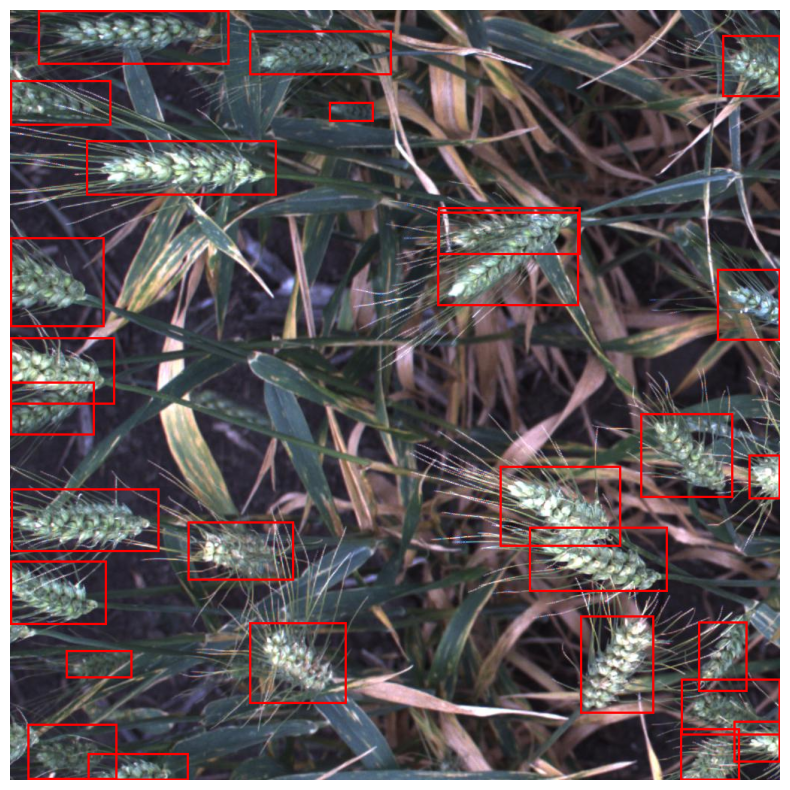

In [1]:
import pandas as pd
import ast
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

# --- 步驟 1: 讀取與探索資料 ---

# 定義檔案路徑
data_dir = './'
train_dir = os.path.join(data_dir, 'train')
train_csv_path = os.path.join(data_dir, 'train.csv')

# 讀取 CSV
df = pd.read_csv(train_csv_path)

# 將 bbox 欄位的字串轉換為 list
df['bbox'] = df['bbox'].apply(ast.literal_eval)

# --- 視覺化一張圖片及其邊界框 ---
image_id_example = df['image_id'].unique()[10]
image_boxes = df[df['image_id'] == image_id_example]
image_path = os.path.join(train_dir, f'{image_id_example}.jpg')

# 讀取圖片並準備繪圖
image = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(image)

# 畫出所有邊界框
for _, row in image_boxes.iterrows():
    box = row['bbox']
    x_min, y_min, width, height = box
    x_max = x_min + width
    y_max = y_min + height
    draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

# 顯示圖片
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [2]:
import torch
from torch.utils.data import Dataset
import torchvision
import pandas as pd
import ast
import os
from PIL import Image

# --- 步驟 2: 建立客製化 PyTorch Dataset ---

class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_dir = image_dir
        self.df = dataframe
        self.transforms = transforms
        self.image_ids = self.df['image_id'].unique()

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, idx: int):
        # 【修正點】用索引 idx 從 image_ids 列表中取出圖片 ID
        image_id = self.image_ids[idx]
        
        # 根據 image_id 篩選出所有相關的標註紀錄
        records = self.df[self.df['image_id'] == image_id]

        # 讀取圖片
        image_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        image = Image.open(image_path).convert("RGB")
        
        # 取得所有邊界框並轉換格式
        boxes_values = records['bbox'].values
        boxes_list = []
        for box in boxes_values:
            x_min, y_min, width, height = box
            x_max = x_min + width
            y_max = y_min + height
            boxes_list.append([x_min, y_min, x_max, y_max])
        
        boxes = torch.as_tensor(boxes_list, dtype=torch.float32)

        # 建立標籤 (labels)，全部都是 1 (代表 "wheat")
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # 建立目標 (target) 字典
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        # 套用 transforms (如果有的話)
        if self.transforms:
            # 注意：物件偵測的 transform 需要能同時處理 image 和 target
            image = self.transforms(image)
            
        return image, target

# 建立物件
train_dataset = WheatDataset(dataframe=df, image_dir='./train/', transforms=torchvision.transforms.ToTensor())

# 取出第一筆資料 (idx=0)
image, target = train_dataset[0]

# 看看回傳的內容
print(f"回傳的圖片類型: {type(image)}")
print(f"回傳的圖片 Tensor 形狀: {image.shape}")
print("\n回傳的 Target 內容:")
print(target)

回傳的圖片類型: <class 'torch.Tensor'>
回傳的圖片 Tensor 形狀: torch.Size([3, 1024, 1024])

回傳的 Target 內容:
{'boxes': tensor([[ 834.,  222.,  890.,  258.],
        [ 226.,  548.,  356.,  606.],
        [ 377.,  504.,  451.,  664.],
        [ 834.,   95.,  943.,  202.],
        [  26.,  144.,  150.,  261.],
        [ 569.,  382.,  688.,  493.],
        [  52.,  602.,  134.,  647.],
        [ 627.,  302.,  749.,  377.],
        [ 412.,  367.,  480.,  449.],
        [ 953.,  220., 1009.,  323.],
        [  30.,   70.,  156.,  203.],
        [  35.,  541.,   81.,  587.],
        [ 103.,   60.,  220.,  143.],
        [ 417.,    4.,  527.,   95.],
        [ 764.,  299.,  883.,  392.],
        [ 539.,   58.,  597.,  188.],
        [ 139.,  274.,  260.,  350.],
        [ 461.,  634.,  579.,  698.],
        [ 215.,  634.,  328.,  709.],
        [ 134.,  903.,  261.,  952.],
        [ 737.,  545.,  824.,  593.],
        [ 292.,  930.,  335.,  976.],
        [   0.,  827.,   86.,  885.],
        [ 324.,   44., 

In [3]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# --- 步驟 3: 準備預訓練的物件偵測模型 ---

# 載入一個在 COCO 上預訓練好的 Faster R-CNN 模型
# weights=...V1 是目前建議的用法
model = fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')

# --- 改造分類頭 ---

# 取得我們資料集的類別數量 (1個類別 'wheat' + 1個背景類別 '_')
num_classes = 2 

# 取得模型分類器的輸入特徵數量
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 用一個新的分類頭替換掉預訓練好的頭
# FastRCNNPredictor 是一個 PyTorch 提供的輔助類別
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 將模型移動到 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print("模型改造完成！")
# 您可以印出 model.roi_heads.box_predictor 來看看，
# 會發現它的 out_features 已經變成 2 了。
print(model.roi_heads.box_predictor)

模型改造完成！
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)


In [4]:
from torch.utils.data import DataLoader

# --- 步驟 4: 訓練模型 ---
# 定義 collate_fn 函數，這是 DataLoader 在組合 batch 時使用的函數
# 這個函數會將每個 batch 的圖片和標註組合成一個 tuple
# 注意：這裡的 collate_fn 需要能處理多個圖片和對應的標註
def collate_fn(batch):
    return tuple(zip(*batch))

# 假設 df 已經讀取並處理好
train_dataset = WheatDataset(dataframe=df, image_dir='./train/', transforms=torchvision.transforms.ToTensor())
# 為了快速示範，我們先用一小部分資料。真實訓練時請移除 subsample
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset_sub = torch.utils.data.Subset(train_dataset, indices[:500])

# 建立 DataLoader，並傳入 collate_fn
# 【關鍵】現在可以使用大於 1 的 batch size 了！
train_loader = DataLoader(
    train_dataset_sub,
    batch_size=4, 
    shuffle=True,
    collate_fn=collate_fn
)

# 將模型移動到 GPU
model.to(device)

# 建立優化器
# 我們只訓練我們替換掉的分類頭的參數
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# 訓練的 epoch 數量
num_epochs = 5

for epoch in range(num_epochs):
    model.train() # 確保模型處於訓練模式
    i = 0
    for images, targets in train_loader:
        # 將圖片和標註都移動到 device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # 【關鍵】模型會直接回傳損失字典
        loss_dict = model(images, targets)

        # 將所有損失加總
        losses = sum(loss for loss in loss_dict.values())

        # 反向傳播
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        i += 1
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {losses.item():.4f}')

print('訓練完成!')

Epoch [1/5], Step [101/125], Loss: 1.0153
Epoch [2/5], Step [101/125], Loss: 0.9216
Epoch [3/5], Step [101/125], Loss: 0.7914
Epoch [4/5], Step [101/125], Loss: 0.5543
Epoch [5/5], Step [101/125], Loss: 0.6544
訓練完成!


In [5]:
from torchmetrics.detection import MeanAveragePrecision

# --- 步驟 5: 評估模型 ---

# 初始化 mAP 計算器
metric = MeanAveragePrecision(box_format='xyxy')

# 建立測試集 DataLoader
test_dataset = WheatDataset(dataframe=df, image_dir='./train/', transforms=torchvision.transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

model.eval() # 將模型設定為評估模式
with torch.no_grad():
    # 遍歷測試集的每一批資料
    for images, targets in test_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # 在 eval 模式下，模型會直接回傳預測結果
        predictions = model(images)
        
        # 將預測結果和真實標註餵給 mAP 計算器
        metric.update(predictions, targets)

# 計算最終的 mAP 分數
results = metric.compute()

print("\n--- 模型評估結果 ---")
# mAP 分數是一個字典，包含了在不同 IoU 門檻和條件下的分數
# 我們主要看 'map' 這個關鍵字，它是在 IoU 0.5-0.95 範圍內的平均 mAP
print(results)


--- 模型評估結果 ---
{'map': tensor(0.4655), 'map_50': tensor(0.8875), 'map_75': tensor(0.4324), 'map_small': tensor(0.1036), 'map_medium': tensor(0.4574), 'map_large': tensor(0.5138), 'mar_1': tensor(0.0159), 'mar_10': tensor(0.1463), 'mar_100': tensor(0.5338), 'mar_small': tensor(0.1811), 'mar_medium': tensor(0.5264), 'mar_large': tensor(0.5795), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(1, dtype=torch.int32)}
